In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [ ]:
path = '/content/drive/MyDrive/DSL/정규세션/Supervised_learning'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [ ]:
os.getcwd()

'/content/drive/MyDrive/DSL/정규세션/Supervised_learning'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [ ]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [ ]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [ ]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [ ]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [ ]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!

In [ ]:
train_x.head()

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


In [ ]:
train_y.head()

0    8179.056
1    8135.640
2    8107.128
3    8048.808
4    8043.624
Name: Wh, dtype: float64

In [ ]:
train_xy = pd.concat([train_x, train_y], axis=1)

In [ ]:
train_xy.head()

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624


In [ ]:
train_xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temp           88 non-null     float64
 1   Wind           88 non-null     float64
 2   Moisture       88 non-null     float64
 3   Precipitation  88 non-null     float64
 4   Sun            88 non-null     float64
 5   Wh             88 non-null     float64
dtypes: float64(6)
memory usage: 4.2 KB


In [ ]:
train_xy.describe()

,Temp,Wind,Moisture,Precipitation,Sun,Wh
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,20.243182,2.630682,71.022727,0.038636,0.290909,8142.186273
std,3.284229,1.082712,15.966903,0.220986,0.415404,203.650160
min,14.800000,0.400000,39.000000,0.000000,0.000000,7784.424000
25%,17.600000,2.000000,59.500000,0.000000,0.000000,8013.006000
50%,20.100000,2.500000,74.500000,0.000000,0.000000,8093.196000
75%,22.175000,3.200000,84.500000,0.000000,0.625000,8264.430000
max,28.200000,5.500000,93.000000,1.900000,1.000000,8663.112000


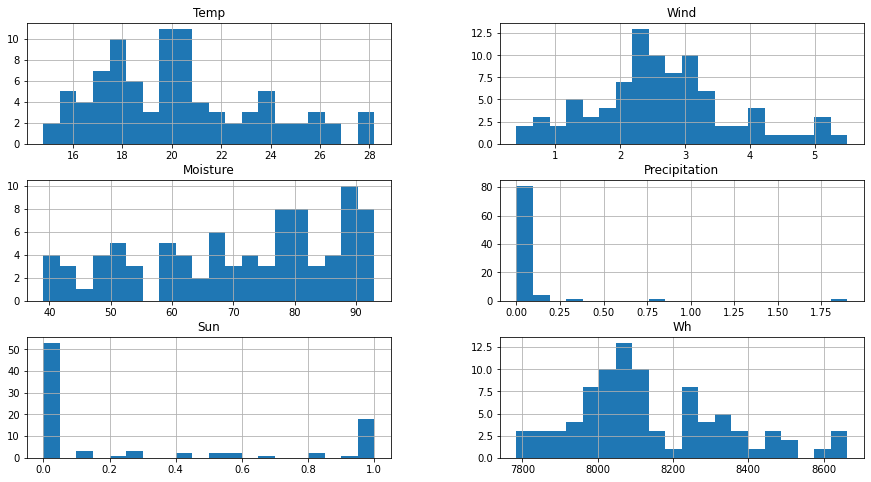

In [ ]:
train_xy.hist(bins=20, figsize=(15, 8))
plt.show()

In [ ]:
train_xy['Sun'].unique()

array([0. , 0.1, 0.3, 0.7, 1. , 0.4, 0.9, 0.2, 0.6, 0.8, 0.5])

In [ ]:
corr_df = train_xy.corr()
corr_df

,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


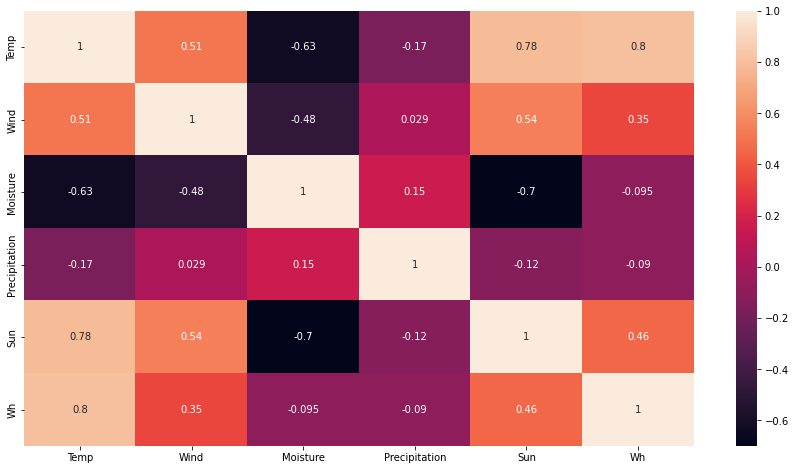

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(corr_df, annot=True)
plt.show()

<Figure size 1080x576 with 0 Axes>

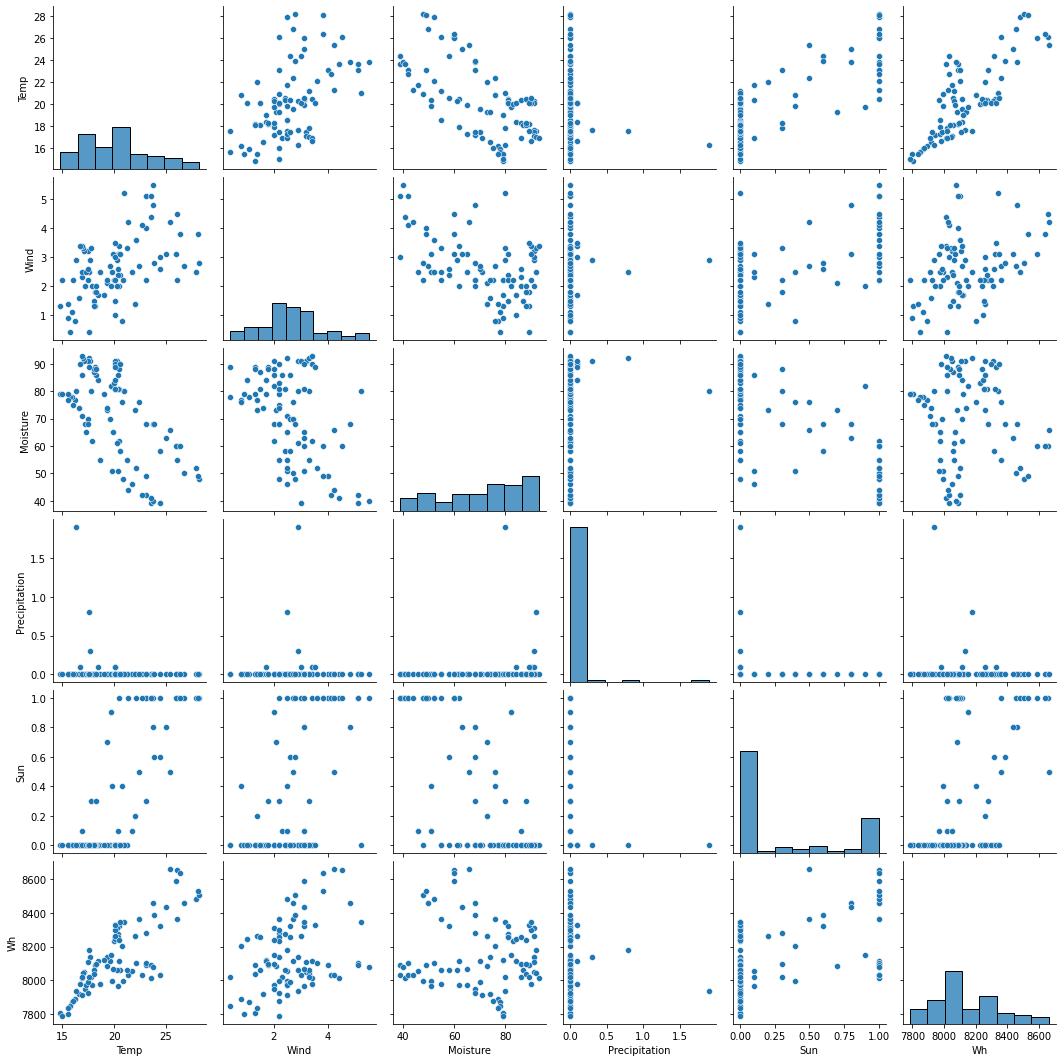

In [ ]:
plt.figure(figsize=(15,8))
sns.pairplot(train_xy, diag_kind = 'hist')
plt.show()

In [ ]:
train_x = train_x[['Temp', 'Wind', 'Sun']]

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 'Temp' : 전력 사용량과 높은 상관관계를 가진다. 'Wind', 'Sun' : 전력 사용량과 낮은 상관관계를 가진다.

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [ ]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)

In [ ]:
train_x.shape

(88, 3)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [ ]:
# 사용할 패키지를 import!
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [ ]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
# ridge model
ridge_model = Ridge().fit(train_x, train_y)

ridge_beta = ridge_model.coef_
ridge_intercept = ridge_model.intercept_
print(f"Ridge Beta :{ridge_beta}")
print(f"Ridge Intercept : {ridge_intercept: .4f}")

# lasso model
lasso_model = Lasso().fit(train_x, train_y)

lasso_beta = lasso_model.coef_
lasso_intercept = lasso_model.intercept_
print(f"Lasso Beta :{lasso_beta}")
print(f"Lasso Intercept : {lasso_intercept: .4f}")

# elasticNet model
elasticnet_model = ElasticNet().fit(train_x, train_y)

elasticnet_beta = elasticnet_model.coef_
elasticnet_intercept = elasticnet_model.intercept_
print(f"ElasticNet Beta :{elasticnet_beta}")
print(f"ElasticNet Intercept : {elasticnet_intercept: .4f}")

Ridge Beta :[224.39487537   1.14356975 -82.758991  ]
Ridge Intercept :  8142.1863
Lasso Beta :[228.51853189   0.         -85.30875049]
Lasso Intercept :  8142.1863
ElasticNet Beta :[102.31658049  10.40731607   4.2952914 ]
ElasticNet Intercept :  8142.1863


## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [ ]:
esti_y_ridge = ridge_model.predict(train_x)
esti_y_lasso = lasso_model.predict(train_x)
esti_y_elasticnet = elasticnet_model.predict(train_x)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [ ]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [ ]:
train_mse_ridge = mse(esti_y_ridge, train_y)
print(f"Ridge {train_mse_ridge:.5f}")

train_mse_lasso = mse(esti_y_lasso, train_y)
print(f"Lasso {train_mse_lasso:.5f}")

train_mse_elasticnet = mse(esti_y_elasticnet, train_y)
print(f"ElasticNet {train_mse_elasticnet:.5f}")

Ridge 11451.98546
Lasso 11432.87770
ElasticNet 17868.19608


In [ ]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [ ]:
# visualization 하실 분은 진행해주세요!
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [ ]:
# transform을 하시는 분들은 실행해주세요
test_x = test_x[['Temp', 'Wind', 'Sun']]
test_x = scaler.transform(test_x)

In [ ]:
# y1_hat에 predict값 할당
pred_y_ridge = ridge_model.predict(test_x)
pred_y_lasso = lasso_model.predict(test_x)
pred_y_elasticnet = elasticnet_model.predict(test_x)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [ ]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [ ]:
test_mse_ridge = mse(pred_y_ridge, test_y)
print(f"Ridge {test_mse_ridge:.5f}")

test_mse_lasso = mse(pred_y_lasso, test_y)
print(f"Lasso {test_mse_lasso:.5f}")

test_mse_elasticnet = mse(pred_y_elasticnet, test_y)
print(f"ElasticNet {test_mse_elasticnet:.5f}")

Ridge 145966.38086
Lasso 143929.20956
ElasticNet 214384.80436


In [ ]:
score(train_mse_ridge,test_mse_ridge)
score(train_mse_lasso,test_mse_lasso)
score(train_mse_elasticnet,test_mse_elasticnet)

 12.7459
 12.5891
 11.9981


In [ ]:
# visualization 하실 분은 진행해주세요!
# visualize(model, test_x, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

## 1 : Temp 변수만 이용하기

In [ ]:
# 처음 모델 예측에 사용한 변수는 Temp, Wind, Sun
# 하지만 Temp와 Wind, Temp와 Sun의 상관관계도 높다!
# Temp 변수만 이용하여 예측을 해보자!
train_x, train_y, test_x, test_y = load_data()

train_x = train_x[['Temp']]
test_x = test_x[['Temp']]

### 데이터 전처리

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train_x)

train_x = scaler.transform(train_x)

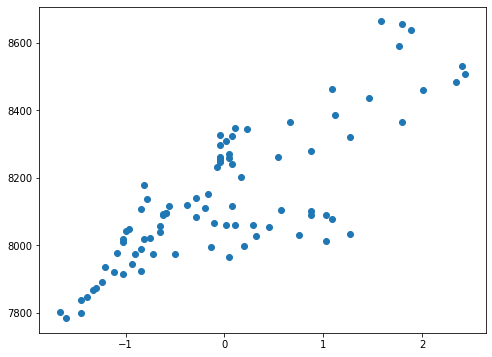

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(train_x, train_y)
plt.show()
# 비선형관계는 아닌듯함!

### 모델 학습

In [ ]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
# ridge model
ridge_model = Ridge().fit(train_x, train_y)

ridge_beta = ridge_model.coef_
ridge_intercept = ridge_model.intercept_
print(f"Ridge Beta :{ridge_beta}")
print(f"Ridge Intercept : {ridge_intercept: .4f}")

# lasso model
lasso_model = Lasso().fit(train_x, train_y)

lasso_beta = lasso_model.coef_
lasso_intercept = lasso_model.intercept_
print(f"Lasso Beta :{lasso_beta}")
print(f"Lasso Intercept : {lasso_intercept: .4f}")

# elasticNet model
elasticnet_model = ElasticNet().fit(train_x, train_y)

elasticnet_beta = elasticnet_model.coef_
elasticnet_intercept = elasticnet_model.intercept_
print(f"ElasticNet Beta :{elasticnet_beta}")
print(f"ElasticNet Intercept : {elasticnet_intercept: .4f}")

Ridge Beta :[160.83255765]
Ridge Intercept :  8142.1863
Lasso Beta :[161.66020035]
Lasso Intercept :  8142.1863
ElasticNet Beta :[108.10680023]
ElasticNet Intercept :  8142.1863


### 모델 추정

In [ ]:
esti_y_ridge = ridge_model.predict(train_x)
esti_y_lasso = lasso_model.predict(train_x)
esti_y_elasticnet = elasticnet_model.predict(train_x)

### Loss 및 시각화

In [ ]:
train_mse_ridge = mse(esti_y_ridge, train_y)
print(f"Ridge {train_mse_ridge:.5f}")

train_mse_lasso = mse(esti_y_lasso, train_y)
print(f"Lasso {train_mse_lasso:.5f}")

train_mse_elasticnet = mse(esti_y_elasticnet, train_y)
print(f"ElasticNet {train_mse_elasticnet:.5f}")

Ridge 14547.09856
Lasso 14544.75828
ElasticNet 17519.83174


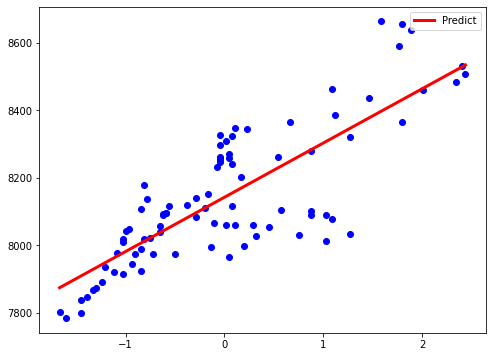

In [ ]:
# visualization 하실 분은 진행해주세요!
visualize(ridge_model, train_x, train_y)

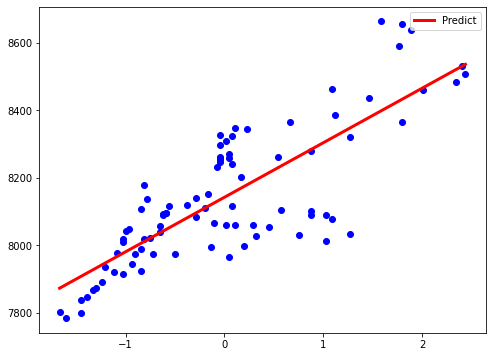

In [ ]:
visualize(lasso_model, train_x, train_y)

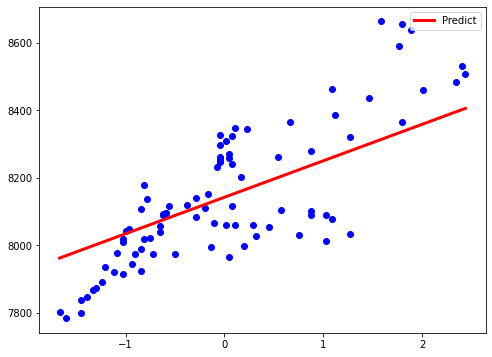

In [ ]:
visualize(elasticnet_model, train_x, train_y)

### 예측

In [ ]:
test_x = scaler.transform(test_x)

In [ ]:
# y1_hat에 predict값 할당
pred_y_ridge = ridge_model.predict(test_x)
pred_y_lasso = lasso_model.predict(test_x)
pred_y_elasticnet = elasticnet_model.predict(test_x)

### 성능 평가

In [ ]:
test_mse_ridge = mse(pred_y_ridge, test_y)
print(f"Ridge {test_mse_ridge:.5f}")

test_mse_lasso = mse(pred_y_lasso, test_y)
print(f"Lasso {test_mse_lasso:.5f}")

test_mse_elasticnet = mse(pred_y_elasticnet, test_y)
print(f"ElasticNet {test_mse_elasticnet:.5f}")

Ridge 198354.83081
Lasso 198221.30641
ElasticNet 207705.28850


In [ ]:
score(train_mse_ridge,test_mse_ridge)
score(train_mse_lasso,test_mse_lasso)
score(train_mse_elasticnet,test_mse_elasticnet)

 13.6354
 13.6284
 11.8554


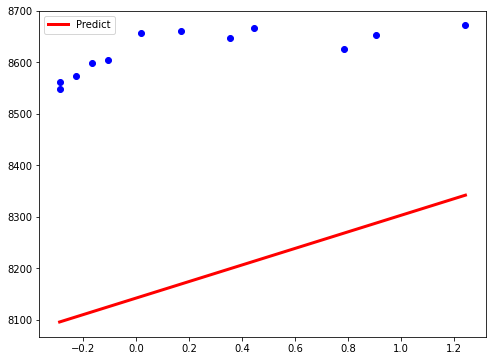

In [ ]:
# visualization 하실 분은 진행해주세요!
visualize(ridge_model, test_x, test_y)

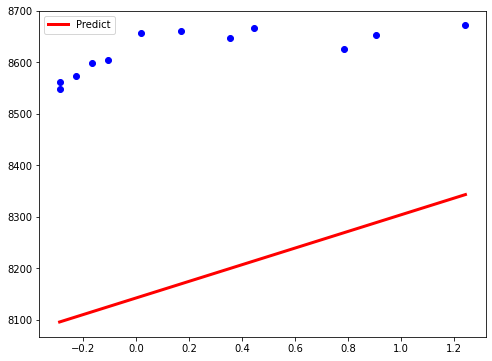

In [ ]:
visualize(lasso_model, test_x, test_y)

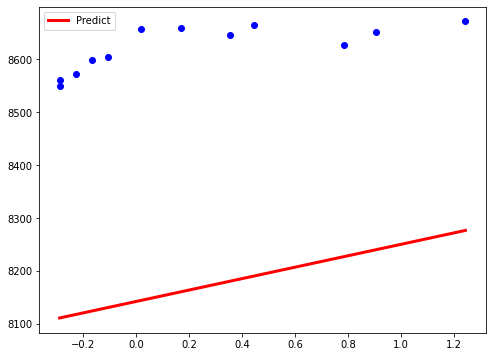

In [ ]:
visualize(elasticnet_model, test_x, test_y)

## 2 : MinMaxScaler 이용

In [ ]:
# 처음 모델 예측에 사용한 변수는 Temp, Wind, Sun
# 하지만 Temp와 Wind, Temp와 Sun의 상관관계도 높다!
# Temp 변수만 이용하여 예측을 해보자!
train_x, train_y, test_x, test_y = load_data()

train_x = train_x[['Temp', 'Wind', 'Sun']]
test_x = test_x[['Temp', 'Wind', 'Sun']]

### 데이터 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(train_x)

train_x = scaler.transform(train_x)

### 모델 학습

In [ ]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
# ridge model
ridge_model = Ridge().fit(train_x, train_y)

ridge_beta = ridge_model.coef_
ridge_intercept = ridge_model.intercept_
print(f"Ridge Beta :{ridge_beta}")
print(f"Ridge Intercept : {ridge_intercept: .4f}")

# lasso model
lasso_model = Lasso().fit(train_x, train_y)

lasso_beta = lasso_model.coef_
lasso_intercept = lasso_model.intercept_
print(f"Lasso Beta :{lasso_beta}")
print(f"Lasso Intercept : {lasso_intercept: .4f}")

# elasticNet model
elasticnet_model = ElasticNet().fit(train_x, train_y)

elasticnet_beta = elasticnet_model.coef_
elasticnet_intercept = elasticnet_model.intercept_
print(f"ElasticNet Beta :{elasticnet_beta}")
print(f"ElasticNet Intercept : {elasticnet_intercept: .4f}")

Ridge Beta :[625.01029065  31.41666063 -68.52413083]
Ridge Intercept :  7894.4953
Lasso Beta :[ 892.84362986    0.         -182.34472735]
Lasso Intercept :  7832.5521
ElasticNet Beta :[62.33033641 19.32794412 47.71651819]
ElasticNet Intercept :  8094.5322


### 모델 추정

In [ ]:
esti_y_ridge = ridge_model.predict(train_x)
esti_y_lasso = lasso_model.predict(train_x)
esti_y_elasticnet = elasticnet_model.predict(train_x)

### Loss 및 시각화

In [ ]:
train_mse_ridge = mse(esti_y_ridge, train_y)
print(f"Ridge {train_mse_ridge:.5f}")

train_mse_lasso = mse(esti_y_lasso, train_y)
print(f"Lasso {train_mse_lasso:.5f}")

train_mse_elasticnet = mse(esti_y_elasticnet, train_y)
print(f"ElasticNet {train_mse_elasticnet:.5f}")

Ridge 13881.14065
Lasso 11523.08338
ElasticNet 33081.17739


### 예측

In [ ]:
test_x = scaler.transform(test_x)

In [ ]:
# y1_hat에 predict값 할당
pred_y_ridge = ridge_model.predict(test_x)
pred_y_lasso = lasso_model.predict(test_x)
pred_y_elasticnet = elasticnet_model.predict(test_x)

### 성능 평가

In [ ]:
test_mse_ridge = mse(pred_y_ridge, test_y)
print(f"Ridge {test_mse_ridge:.5f}")

test_mse_lasso = mse(pred_y_lasso, test_y)
print(f"Lasso {test_mse_lasso:.5f}")

test_mse_elasticnet = mse(pred_y_elasticnet, test_y)
print(f"ElasticNet {test_mse_elasticnet:.5f}")

Ridge 185664.93827
Lasso 150024.31675
ElasticNet 241434.84992


In [ ]:
score(train_mse_ridge,test_mse_ridge)
score(train_mse_lasso,test_mse_lasso)
score(train_mse_elasticnet,test_mse_elasticnet)

 13.3753
 13.0195
 7.2983


고생하셨습니다!